# 0. Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict
import time
from datetime import timedelta

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import torch
import torch.nn as nn
from torchsummary import summary
from torch.utils.data import DataLoader
torch.manual_seed(123)

# 1. Data Read In

In [2]:
cn7 = pd.read_csv("../data/processed/labeled_data_cn7.csv", parse_dates=True)

# 2. Data Preprocessing

In [3]:
# Preparation of features for model training
numerical_features = [x for x in cn7.columns if np.dtype(cn7[x]) == "float64"]

In [4]:
# Data for passed parts
cn7_Y = cn7[cn7["PassOrFail"] == 0]
cn7_Y = cn7_Y[numerical_features]
print("No. of passed CN7 parts:", len(cn7_Y))

No. of passed CN7 parts: 3946


In [5]:
# Data for failed parts
cn7_N = cn7[cn7["PassOrFail"] == 1]
cn7_N = cn7_N[numerical_features]
print("No. of failed CN7 parts:", len(cn7_N))

No. of failed CN7 parts: 28


In [6]:
# The autoencoder is trained by Data for passed parts (i.e., data with a majority class)
cn7_train_Y, cn7_test_Y = train_test_split(cn7_Y, test_size=0.1)

# Test set with failed parts
cn7_test_N = cn7_N

print(f"No. of Train Set (Passed Parts): {len(cn7_train_Y)}")
print(f"No. of Test Set (Passed Parts): {len(cn7_test_Y)}")
print(f"No. of Test Set (Failed Parts): {len(cn7_test_N)}")

No. of Train Set (Passed Parts): 3551
No. of Test Set (Passed Parts): 395
No. of Test Set (Failed Parts): 28


In [7]:
# Data normalization

scaler = StandardScaler()

cn7_train_Y = scaler.fit_transform(cn7_train_Y)
cn7_test_Y = scaler.transform(cn7_test_Y)
cn7_test_N = scaler.transform(cn7_test_N)

# 3. Variational Autoencoder

In [8]:
# Autoencoder Class

class VariationalAutoEncoder(nn.Module):
    def __init__(self):
        super(VariationalAutoEncoder, self).__init__()
        self.N = torch.distributions.Normal(0, 1)
        self.kl = 0
        
        self.enc = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(cn7_train_Y.shape[1], 15),
            nn.ReLU(),
            nn.Linear(15, 5),
            nn.ReLU(),
            nn.Linear(5, 1),
        )
        
        self.dec = nn.Sequential(
            nn.Linear(1, 5),
            nn.ReLU(),
            nn.Linear(5, 15),
            nn.ReLU(),
            nn.Linear(15, cn7_train_Y.shape[1]),
        )
        
    def forward(self, x):
        x = self.enc(x)
        mu = x
        sigma = torch.exp(x)
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()  # Came from Kullback-Leibler Divergence
        return self.dec(z)

In [9]:
# Training Parameters

batch_size = 30
lr = 0.001   # learning rate
w_d = 1e-4  # weight decay
epochs = 100

In [10]:
# Loader Preparation

class Loader(torch.utils.data.Dataset):
    def __init__(self):
        super(Loader, self).__init__()
        self.dataset = ''
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        row = self.dataset[idx]
        data = torch.from_numpy(row).float()
        return data
    
    
class CN7DataLoader(Loader):
    def __init__(self, data_for_ae):
        super(CN7DataLoader, self).__init__()
        self.dataset = data_for_ae

In [11]:
# train/validation sets split

cn7_train_Y_t, cn7_train_Y_v = train_test_split(
    cn7_train_Y, test_size=0.2, random_state=123
)

In [12]:
train_set = CN7DataLoader(cn7_train_Y_t)

train_ = DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=True,
    drop_last=True
)

In [13]:
valid_set = CN7DataLoader(cn7_train_Y_v)

valid_ = DataLoader(
    valid_set,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=True,
    drop_last=True
)

In [14]:
metrics = defaultdict(list)
device = 'cpu'       #'cuda' if torch.cuda.is_available() else 'cpu'
model = VariationalAutoEncoder()
model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    model.parameters(), lr=lr, weight_decay=w_d
)

In [15]:
summary(model, (23, ), device='cpu');

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1]                   --
|    └─Dropout: 2-1                      [-1, 23]                  --
|    └─Linear: 2-2                       [-1, 15]                  360
|    └─ReLU: 2-3                         [-1, 15]                  --
|    └─Linear: 2-4                       [-1, 5]                   80
|    └─ReLU: 2-5                         [-1, 5]                   --
|    └─Linear: 2-6                       [-1, 1]                   6
├─Sequential: 1-2                        [-1, 23]                  --
|    └─Linear: 2-7                       [-1, 5]                   10
|    └─ReLU: 2-8                         [-1, 5]                   --
|    └─Linear: 2-9                       [-1, 15]                  90
|    └─ReLU: 2-10                        [-1, 15]                  --
|    └─Linear: 2-11                      [-1, 23]                  368
Total params: 

In [16]:
# VAE Training

model.train()
start = time.time()
for epoch in range(epochs):
    ep_start = time.time()
    
    # Training
    running_loss_t = 0.0

    for bx, (data) in enumerate(train_):
        sample = model(data.to(device))
        loss = criterion(data.to(device), sample)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss_t += loss.item()
    train_loss = running_loss_t/len(train_set)
    metrics['train_loss'].append(train_loss)
    
    # Validation
    model.eval()
    running_loss_v = 0.0
    with torch.no_grad():
        for bx, (data) in enumerate(valid_):
            sample = model(data.to(device))
            loss = criterion(data.to(device), sample)
            accuracy = torch.sum(torch.isclose(data.to(device), sample, rtol=0.1))
            running_loss_v += loss.item()
    valid_loss = running_loss_v/len(valid_set)
    metrics['valid_loss'].append(valid_loss)
    
    model.train()
    
    ep_end = time.time()
    if (epoch+1) % 5 == 0:
        print('-----------------------------------------------')
        print('[EPOCH] {}/{}\n[TRAIN LOSS] {}    [VALID LOSS] {}'.format(epoch+1, epochs, train_loss, valid_loss))
        print('Epoch Complete in {}'.format(timedelta(seconds=ep_end-ep_start)))
end = time.time()
print('-----------------------------------------------')
print('[System Complete: {}]'.format(timedelta(seconds=end-start)))

-----------------------------------------------
[EPOCH] 5/100
[TRAIN LOSS] 0.028280732329462616    [VALID LOSS] 0.03470425163140277
Epoch Complete in 0:00:00.178004
-----------------------------------------------
[EPOCH] 10/100
[TRAIN LOSS] 0.02710759272457848    [VALID LOSS] 0.027130492754626374
Epoch Complete in 0:00:00.200023
-----------------------------------------------
[EPOCH] 15/100
[TRAIN LOSS] 0.025017443126146222    [VALID LOSS] 0.03308415899129189
Epoch Complete in 0:00:00.179999
-----------------------------------------------
[EPOCH] 20/100
[TRAIN LOSS] 0.02156505712216169    [VALID LOSS] 0.0330144935267887
Epoch Complete in 0:00:00.178001
-----------------------------------------------
[EPOCH] 25/100
[TRAIN LOSS] 0.020897747602471164    [VALID LOSS] 0.020371359884319762
Epoch Complete in 0:00:00.175968
-----------------------------------------------
[EPOCH] 30/100
[TRAIN LOSS] 0.01992247326588127    [VALID LOSS] 0.021528518359201703
Epoch Complete in 0:00:00.179006
------

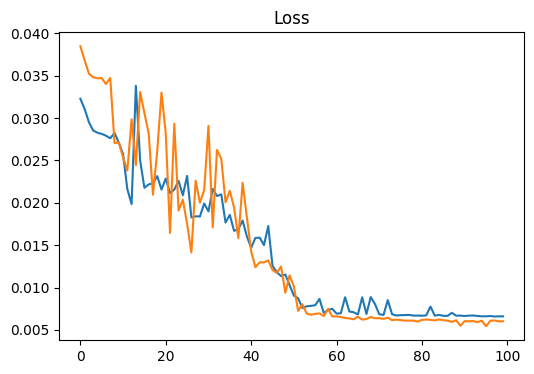

In [17]:
# Loss

_, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.set_title('Loss')
ax.plot(metrics['train_loss'])
ax.plot(metrics['valid_loss'])
plt.show();

# 4. Setup of Threshold

In [18]:
# Prediction on the train set

cn7_train_pred = model(torch.tensor(cn7_train_Y).float())

In [19]:
# The error between the prediction and true value

difference = cn7_train_pred.detach().numpy() - cn7_train_Y

cn7_train_loss = np.mean(np.square(difference), axis=1)

In [20]:
# Threshold was calculated based on 0.5 sigma value of the error 
# between the prediction and true value

# The sigma value can act as tuning parameter for autoencoder

threshold = np.mean(cn7_train_loss) + 0.5*np.std(cn7_train_loss)
print("Threshold: ", threshold)

Threshold:  0.702709579850725


# 5. Classification of Test Set by Autoencoder

## 5.1. Evaluation Using Test Set (Passed Parts)

In [21]:
# Prediction by autoencoder
cn7_predict_Y = model(torch.tensor(cn7_test_Y).float())

In [22]:
# The error between the prediction and true value

cn7_test_Y_mse = np.mean(np.square(cn7_predict_Y.detach().numpy() - cn7_test_Y), axis=1)

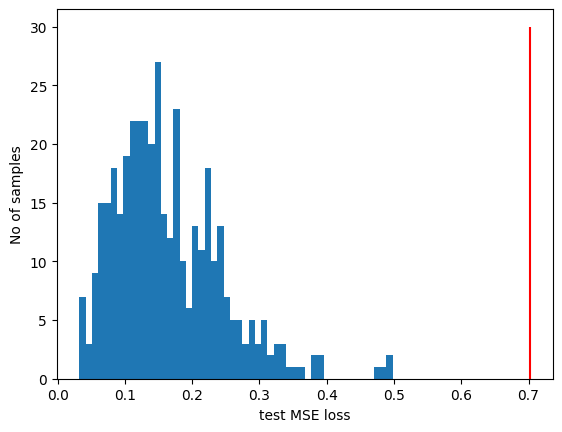

In [23]:
# Data visualization 

plt.hist(cn7_test_Y_mse, bins=50)
plt.xlabel("test MSE loss")
plt.ylabel("No of samples")
plt.vlines(threshold, 0, 30, color="red")
plt.show();

In [24]:
# Check on the data that were predicted as failed parts

cn7_test_Y_anomalies = cn7_test_Y_mse > threshold
print("No. of Failed Parts:", np.sum(cn7_test_Y_anomalies))
print("Accuracy:", (cn7_test_Y.shape[0]-np.sum(cn7_test_Y_anomalies))/cn7_test_Y.shape[0])

No. of Failed Parts: 0
Accuracy: 1.0


## 5.2. Evaluation Using Test Set (Failed Parts)

In [25]:
# Prediction by autoencoder
cn7_predict_N = model(torch.tensor(cn7_test_N).float())

In [26]:
# The error between the prediction and true value

cn7_test_N_mse = np.mean(np.square(cn7_predict_N.detach().numpy() - cn7_test_N), axis=1)

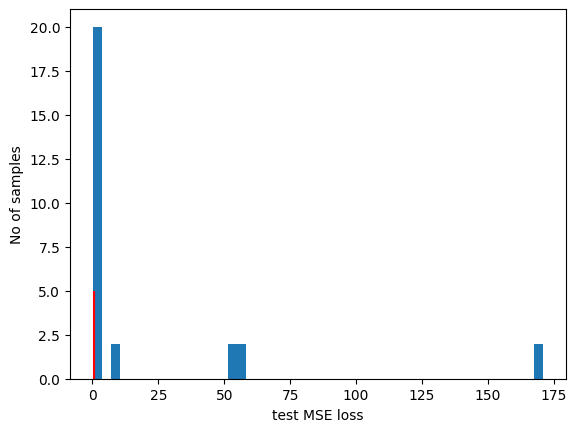

In [27]:
# Data visualization

plt.hist(cn7_test_N_mse, bins=50)
plt.xlabel("test MSE loss")
plt.ylabel("No of samples")
plt.vlines(threshold, 0, 5, color="red")
plt.show();

In [28]:
# Check on the data that were predicted as failed parts

cn7_test_N_anomalies = cn7_test_N_mse > threshold
print("No. of Failed Parts:", np.sum(cn7_test_N_anomalies))
print("Accuracy:", np.sum(cn7_test_N_anomalies)/cn7_test_N.shape[0])

No. of Failed Parts: 16
Accuracy: 0.5714285714285714


# 6. Result Analysis

In [29]:
# True values for the test set

cn7_true = np.concatenate(
    [np.zeros(len(cn7_test_Y_anomalies)), np.ones(len(cn7_test_N_anomalies))]
)

In [30]:
# Predicted values for the test set

cn7_prediction = np.concatenate(
    [cn7_test_Y_anomalies, cn7_test_N_anomalies]
)

In [31]:
confusion_matrix(cn7_true, cn7_prediction)

array([[395,   0],
       [ 12,  16]], dtype=int64)

In [32]:
print(classification_report(cn7_true, cn7_prediction))

              precision    recall  f1-score   support

         0.0       0.97      1.00      0.99       395
         1.0       1.00      0.57      0.73        28

    accuracy                           0.97       423
   macro avg       0.99      0.79      0.86       423
weighted avg       0.97      0.97      0.97       423



- Performance of the autoencoder model was most effective among the three models tested for `CN7` parts
- However, it should be also noted that the performance was greatly affected by the sigma value for determining the threshold.